# Combining queries — a submission to MSMARCO Document challenge

In this example, we'll walk through the process of building a more complete and complex query for the MSMARCO Document dataset. This assumes that you are familiar with optimizing a basic query as shown in the "Query Tuning" notebook. We'll be using that query and the optimal parameters found there as the foundation on which we build a more complex query.

As with the previous notebook and in accordance with the MSMARCO Document ranking task, we'll continue to use MRR@100 on the `dev` dataset for evaluation and comparison with other approaches.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import importlib
import os
import sys

from elasticsearch import Elasticsearch
from skopt.plots import plot_objective

In [5]:
# project library
sys.path.insert(0, os.path.abspath('..'))

import qopt
importlib.reload(qopt)

from qopt.notebooks import evaluate_mrr100_dev, optimize_query_mrr100
from qopt.optimize import Config

In [6]:
# use a local Elasticsearch or Cloud instance (https://cloud.elastic.co/)
# es = Elasticsearch('http://localhost:9200')
es = Elasticsearch('http://35.234.93.126:9200')

# set the parallelization parameter `max_concurrent_searches` for the Rank Evaluation API calls
max_concurrent_searches = 30

## Starting point: cross_fields

Let's quickly review the steps we made in the "Query Tuning" notebook. We first used a `multi_match` `cross_fields` query which searches for terms across the `url`, `title` and `body` fields of our documents. We set the parameters to their defualt values and found an MRR@100 of about `0.248`.

Next we optimized all of the parameters trying both stepwise and then all-in-one using Bayesian optimization. We evaluated again and found an MRR@100 of about `0.296`, which is quite a decent improvement over the baseline with default parameters.

Below are the optimial parameters that we found, and we'll reuse them in this notebook. Since we'll have multiple queries and sometimes the parameter names will be the same, we'll namespace them and prefix the names with `multi_match|cross_fields|`.

In [7]:
cross_fields_params = {
    'multi_match|cross_fields|operator': 'OR',
    'multi_match|cross_fields|minimum_should_match': 40,
    'multi_match|cross_fields|tie_breaker': 0.2956536905591155,
    'multi_match|cross_fields|url|boost': 1.03035723802844,
    'multi_match|cross_fields|title|boost': 10.0,
    'multi_match|cross_fields|body|boost': 6.270734180132099,
}

## Alternative query: best_fields

The first query type we used was a `multi_match` `cross_fields` query. This searches for query terms individually across each of the three document fields. For example, given a query string "impact of the success of the manhattan project", we search for each of the query terms in each of the fields. So we could have "impact" matching the body only, while "manhattan" could match all three fields. Due to the nature of the queries which are all questions, this might not be the best query type to use.

In this step, we're going to try using [the `multi_match` query of type `best_fields`](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-multi-match-query.html#type-best-fields). This variant will look across fields but will only return the field and score with the best matches. We will also experiment in this query with modifying a few parameters of the query that are sometimes hard to guess at. Specifically, we'll explore which field boosts to use for each of our three fields and also which `tie_breaker` parameter to use.

Here's the baseline query with default parameter values.

In [10]:
%%time

_ = evaluate_mrr100_dev(es, max_concurrent_searches,
    template_id='best_fields',
    params={
        'tie_breaker': 0.0,
        'url|boost': 1.0,
        'title|boost': 1.0,
        'body|boost': 1.0,
    })

Score: 0.2799
CPU times: user 2 s, sys: 609 ms, total: 2.61 s
Wall time: 41.9 s


That's pretty impressive for the baseline query. It beats our baseline `cross_fields` query, but not quite the optimized one.

Let's try and optimize this `best_fields` query now. We'll put all the parameters into a single large parameter space and use Bayesian optimization again to find the optimal parameters.

In [ ]:
%%time

_, _, final_params_best_fields, metadata_best_fields = optimize_query_mrr100(es, max_concurrent_searches,
    template_id='best_fields',
    config_space=Config.parse({
        'num_iterations': 50,
        'num_initial_points': 10,
        'space': {
            'tie_breaker': { 'low': 0.0, 'high': 1.0 },
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
        },
    }))

Optimizing parameters
 - iteration 1 scored 0.1984 with: {'tie_breaker': 0.835838815676778, 'url|boost': 2.1391555484465115, 'title|boost': 5.936928134478353, 'body|boost': 0.3575464234918591}
 - iteration 2 scored 0.2216 with: {'tie_breaker': 0.19602557614706223, 'url|boost': 1.6274001250661898, 'title|boost': 7.0026441707216165, 'body|boost': 1.9315136389573557}
 - iteration 3 scored 0.2130 with: {'tie_breaker': 0.08468148306233948, 'url|boost': 2.830814282996708, 'title|boost': 4.762862153679114, 'body|boost': 0.3827282100351626}
 - iteration 4 scored 0.1745 with: {'tie_breaker': 0.9201958324424367, 'url|boost': 8.066784849357466, 'title|boost': 6.824341099584542, 'body|boost': 2.6312453869077395}
 - iteration 5 scored 0.2219 with: {'tie_breaker': 0.0028070460397922052, 'url|boost': 7.222439197401668, 'title|boost': 5.587857721081876, 'body|boost': 5.352059296430413}
 - iteration 6 scored 0.1901 with: {'tie_breaker': 0.8481483243709104, 'url|boost': 5.675405086773165, 'title|boost':

In [ ]:
%%time

_ = evaluate_mrr100_dev(es, max_concurrent_searches, template_id='best_fields', params=best_params_best_fields)

In [ ]:
_ = plot_objective(metadata_best_fields, sample_source='result')

Interesting that the best weights are almost equal across the fields. This starts to explain how the baseline query with all weights equal was so good. Let's run the evaluation with just the tuned weights to see how much we improve over the baseline.

In [28]:
%%time

results = evaluate_mrr100_dev(es, template_id='best_fields', params=final_params_1)

Score: 0.2865
CPU times: user 2.33 s, sys: 1.25 s, total: 3.58 s
Wall time: 1min 18s


Ok, so we have some progress, albeit not very much. Let's continue and try optimizing the last parameters of this query to see if we get a bigger boost.

We can now take the best parameters found for the field weights, set them as constants or `default` values for the template, and just focus the next optimization on picking the last parameters.

Since we have a pretty small search space with just a few possible values per pameter, if we just give sequences, the optimizer will actually choose a grid search here and test every possible combination of the two parameters.

In [35]:
%%time

best_score_2, best_params_2, final_params_2, metadata_2 = optimize_query_mrr100(es,
    template_id='best_fields',
    config_space=Config.parse({
        'num_iterations': 50,
        'num_initial_points': 10,
        'space': {
            'operator': ['OR', 'AND'],
            'minimum_should_match': [1, 2, 3, 4, 5],
        },
        'default': best_params_1
    }),
    verbose=True)

Optimizing parameters
 - iteration 1 scored 0.2494 with: {'minimum_should_match': 1, 'operator': 'OR'}
 - iteration 2 scored 0.0000 with: {'minimum_should_match': 1, 'operator': 'AND'}
 - iteration 3 scored 0.2354 with: {'minimum_should_match': 2, 'operator': 'OR'}
 - iteration 4 scored 0.0000 with: {'minimum_should_match': 2, 'operator': 'AND'}
 - iteration 5 scored 0.1981 with: {'minimum_should_match': 3, 'operator': 'OR'}
 - iteration 6 scored 0.0000 with: {'minimum_should_match': 3, 'operator': 'AND'}
 - iteration 7 scored 0.1389 with: {'minimum_should_match': 4, 'operator': 'OR'}
 - iteration 8 scored 0.0000 with: {'minimum_should_match': 4, 'operator': 'AND'}
 - iteration 9 scored 0.0828 with: {'minimum_should_match': 5, 'operator': 'OR'}
 - iteration 10 scored 0.0000 with: {'minimum_should_match': 5, 'operator': 'AND'}
Best score: 0.2494
Best params: {'minimum_should_match': 1, 'operator': 'OR'}
Final params: {'url|weight': 9.682062830345467, 'title|weight': 10.0, 'body|weight':

Even after trying a bunch of options, it turns out that the defaults for `operator` and `minimum_should_match` are actually the best! Even though we didn't find better values, we did learn something in the process.

We now don't need to do another evaluation since there was no change after tuning these last two operators.

## Combining queries

We've seen the process to optimize field weights on two different `multi_match` queries but it would be interesting to see if combining them with in a parent `bool` query might actually result in even better MRR@100. Let's give it a shot and find out.

We'll combine the two queries by using a `bool` query with a `should` clause. That means that we don't require both queries to match documents, but we will combine the scores when they do. Using the `combined` template, we can use the previously discovered optimal field weights, and add some new parameters for query `boost`s to decide how we should combine these two queries.

Side note: Combining queries in this way may improve relevance as measured by MRR@100, but it will hurt performance and the query times will be quite a lot higher than with a single, simpler query. Keep this in mind when building complex queries for production!

Here's the baselines that we'll compare against when trying to combine these queries in an optimal way. First a combined query with all parameters default values, and second a combined query using the optimal field weights previously found.

In [57]:
%%time

results = evaluate_mrr100_dev(es,
    template_id='combined',
    params={
        # default weights
        'multi_match|cross_fields|url|weight': 1.0,
        'multi_match|cross_fields|title|weight': 1.0,
        'multi_match|cross_fields|body|weight': 1.0,
        'multi_match|best_fields|url|weight': 1.0,
        'multi_match|best_fields|title|weight': 1.0,
        'multi_match|best_fields|body|weight': 1.0,
        # default boosts
        'multi_match|cross_fields|boost': 1.0,
        'multi_match|best_fields|boost': 1.0,
    })

Score: 0.2798
CPU times: user 5.01 s, sys: 1.66 s, total: 6.66 s
Wall time: 6min 52s


Not bad, but I think we can do better by using the optimal field weights.

In [16]:
%%time

# BM25 params from default ES
set_bm25_parameters(es, 'msmarco-document', **{'k1': 1.2, 'b': 0.75})

results = evaluate_mrr100_dev(es,
    template_id='combined',
    params={
        # optimal weights
        'multi_match|cross_fields|url|weight': 10.0,
        'multi_match|cross_fields|title|weight': 10.0,
        'multi_match|cross_fields|body|weight': 5.17,
        'multi_match|best_fields|url|weight': 9.682,
        'multi_match|best_fields|title|weight': 10.0,
        'multi_match|best_fields|body|weight': 8.746,
        # default boosts
        'multi_match|cross_fields|boost': 1.0,
        'multi_match|best_fields|boost': 1.0,
    })

Score: 0.3027
CPU times: user 4.77 s, sys: 1.62 s, total: 6.4 s
Wall time: 6min 8s


In [15]:
%%time

# BM25 params from cross_fields
set_bm25_parameters(es, 'msmarco-document', **best_params_a)

results = evaluate_mrr100_dev(es,
    template_id='combined',
    params={
        # optimal weights
        'multi_match|cross_fields|url|weight': 10.0,
        'multi_match|cross_fields|title|weight': 10.0,
        'multi_match|cross_fields|body|weight': 5.17,
        'multi_match|best_fields|url|weight': 9.682,
        'multi_match|best_fields|title|weight': 10.0,
        'multi_match|best_fields|body|weight': 8.746,
        # default boosts
        'multi_match|cross_fields|boost': 1.0,
        'multi_match|best_fields|boost': 1.0,
    })

Score: 0.2728
CPU times: user 3.79 s, sys: 1.01 s, total: 4.79 s
Wall time: 6min 21s


In [14]:
%%time

# BM25 params from best_fields
set_bm25_parameters(es, 'msmarco-document', **best_params_0)

results = evaluate_mrr100_dev(es,
    template_id='combined',
    params={
        # optimal weights
        'multi_match|cross_fields|url|weight': 10.0,
        'multi_match|cross_fields|title|weight': 10.0,
        'multi_match|cross_fields|body|weight': 5.17,
        'multi_match|best_fields|url|weight': 9.682,
        'multi_match|best_fields|title|weight': 10.0,
        'multi_match|best_fields|body|weight': 8.746,
        # default boosts
        'multi_match|cross_fields|boost': 1.0,
        'multi_match|best_fields|boost': 1.0,
    })

Score: 0.3011
CPU times: user 4.25 s, sys: 1.36 s, total: 5.61 s
Wall time: 5min 32s


That's already quite a better than either the `cross_fields` or `best_fields` queries on their own.

As before, let's continue and see if there is an improvement by tuning the boosts on each query. We've got a smaller parameter space to search over, so we'll specify running fewer iterations than before since these queries run a lot slower.

In [69]:
%%time

best_score_3, best_params_3, final_params_3, metadata_3 = optimize_query_mrr100(es,
    template_id='combined',
    config_space=Config.parse({
        'num_iterations': 30,
        'num_initial_points': 5,
        'space': {
            'multi_match|cross_fields|boost': { 'low': 0.0, 'high': 5.0 },
            'multi_match|best_fields|boost': { 'low': 0.0, 'high': 5.0 },
        },
        'default': {
            'multi_match|cross_fields|url|weight': 10.0,
            'multi_match|cross_fields|title|weight': 10.0,
            'multi_match|cross_fields|body|weight': 5.17,
            'multi_match|best_fields|url|weight': 9.682,
            'multi_match|best_fields|title|weight': 10.0,
            'multi_match|best_fields|body|weight': 8.746,
        },
    }),
    verbose=True)

Optimizing parameters
 - iteration 1 scored 0.2725 with: {'multi_match|cross_fields|boost': 2.547577325223018, 'multi_match|best_fields|boost': 0.5471916531942151}
 - iteration 2 scored 0.2694 with: {'multi_match|cross_fields|boost': 2.6798639019055748, 'multi_match|best_fields|boost': 1.633720712857639}
 - iteration 3 scored 0.2683 with: {'multi_match|cross_fields|boost': 3.2768751918169867, 'multi_match|best_fields|boost': 3.2879218237613235}
 - iteration 4 scored 0.2551 with: {'multi_match|cross_fields|boost': 0.7909425127149035, 'multi_match|best_fields|boost': 4.947870579130785}
 - iteration 5 scored 0.2697 with: {'multi_match|cross_fields|boost': 2.8534793222286603, 'multi_match|best_fields|boost': 1.4987177123346775}
 - iteration 6 scored 0.2517 with: {'multi_match|cross_fields|boost': 5.0, 'multi_match|best_fields|boost': 0.0}
 - iteration 7 scored 0.2517 with: {'multi_match|cross_fields|boost': 1.3248474705567896, 'multi_match|best_fields|boost': 0.0}
 - iteration 8 scored 0.2

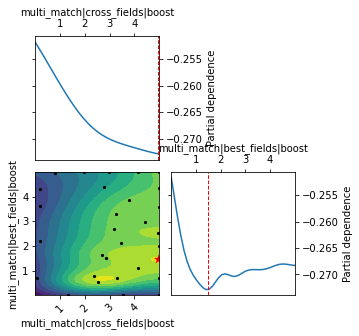

In [70]:
_ = plot_objective(metadata_3, sample_source='result')

In [71]:
%%time

results = evaluate_mrr100_dev(es, template_id='combined', params=final_params_3)

Score: 0.2930
CPU times: user 3.76 s, sys: 1.85 s, total: 5.62 s
Wall time: 13min 24s


So that's kind of odd. We couldn't actually find boost parameters that were better than the defaults `1.0`. I wonder what's going on here. Let's break this down and see if we can figure it out.

The first thing to note 

In [65]:
def collect_scores_cross_fields(query_string):
    res = es.search(index='msmarco-document', size=100, body={ "query": {
        "multi_match": {
            "type": "cross_fields",
            "query": query_string,
            "fields": [
                "url^10.0",
                "title^10.0",
               "body^5.17"
            ],
            "operator": "OR",
            "boost": "1.0"
      }
    }})
    return [hit['_score'] for hit in res['hits']['hits']]

def collect_scores_best_fields(query_string):
    res = es.search(index='msmarco-document', size=100, body={ "query": {
        "multi_match": {
            "type": "best_fields",
            "query": query_string,
            "fields": [
                "url^9.682",
                "title^10.0",
               "body^8.746"
            ],
            "operator": "OR",
            "boost": "1.0"
      }
    }})
    return [hit['_score'] for hit in res['hits']['hits']]

def collect_scores(queries):
    cross_field_scores = []
    best_field_scores = []

    for query in list(queries):
        cfs = collect_scores_cross_fields(query[1])
        bfs = collect_scores_best_fields(query[1])
        
        # keep just n scores to make sure the lists are the same length
        length = min(len(cfs), len(bfs))
        cross_field_scores.append(cfs[:length])
        best_field_scores.append(bfs[:length])

    return cross_field_scores, best_field_scores

In [66]:
from qopt.trec import load_queries_as_tuple
from qopt.notebooks import ROOT_DIR

queries = load_queries_as_tuple(os.path.join(ROOT_DIR, 'data', 'msmarco-document-sampled-queries.1000.tsv'))
cfs, bfs = collect_scores(queries)

In [67]:
from itertools import chain

cfs_flat = list(chain(*cfs))
bfs_flat = list(chain(*bfs))

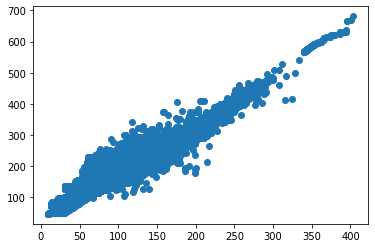

In [68]:
import matplotlib.pyplot as plt
plt.scatter(cfs_flat, bfs_flat)
plt.show()